### Projectile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp

In [19]:
class Projectile():
	def __init__(self, r0, v0, t_span, c, g=9.81):
		"""
		Initializes a projectile object with initial position r0, initial velocity v0, time span t_span, air friction coeficient c and acceleration due to gravity g.
		"""
		self.t = t_span
		x0, y0 = r0
		vx0, vy0 = v0
		self.x = x0
		self.y = y0
		self.c = c
	
	def trajectory(self):
		"""
		Returns the trajectory of the projectile (with aire resistance).
		"""
		pass
		

	def peak(self):
		"""
		Returns the time, x and y coordinates of the peak of the projectile trajectory.
		"""
		return self.t[np.argmax(self.y)], self.x[np.argmax(self.y)], np.max(self.y)

In [20]:
p = Projectile((0, 0), (10, 20), np.linspace(0, 5, 40))

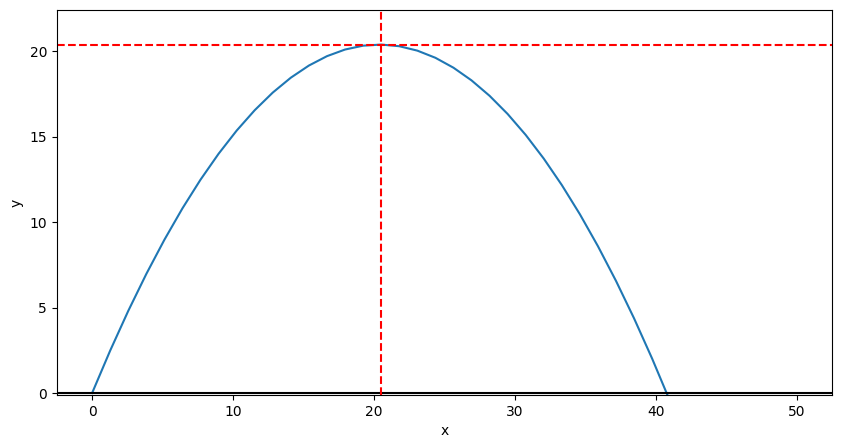

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(p.x, p.y)
plt.axhline(0, color='k')
plt.axhline(p.peak()[2], color='r', linestyle='--')
plt.axvline(p.peak()[1], color='r', linestyle='--')
plt.ylim(-0.1, p.peak()[2]*1.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Body Diagram

Using Newton's Second Law:

$ \sum \vec{F} = m \vec{a} $

- Friction:

	We need to define the behaviour of the friction force.
	Using an usual friction defined as:

	$$ \vec{F_f} = -\beta |\vec{v}| \vec{v} $$

	where $\beta$ is the friction coefficient and $\vec{v}$ the velocity.

- Equations of motion:

	$\vec r = (x, y)$

	Applying Newton's Second Law to the horizontal and vertical directions:
	$$ \vec{F_g} + \vec{F_f} = m \ddot{\vec{r}} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} + m \ddot{y} \hat{y} $$

	Separating the equations:

	$$ \vec{F_g} + \vec{F_f} = m \ddot{x} \hat{x} $$
	$$ \vec{F_g} + \vec{F_f} = m \ddot{y} \hat{y} $$

	Subsituting the friction force and the gravity force:
	$$ m \ddot{x} = -\beta |\vec{v}| \dot{x}  $$ 
	$$ m \ddot{y}  = -mg -\beta |\vec{v}| \dot{y}  $$

	Rearranging the equations and substituting r' = r/g (to use dimensionless units):
	$$ \ddot{x'} = -\frac{\beta g}{m} |\vec{v'}| \dot{x'} $$
	$$ \ddot{y'} = -1 -\frac{\beta g}{m} |\vec{v'}| \dot{y'} $$

We have 2 second order ODEs, we can separate them into 4 first order ODEs:
- $ \dot{x'} = v'_{x'} $
- $ \dot{y'} = v'_{y'} $
- $ \dot{v'_{x'}} = -\frac{\beta g}{m} |\vec{v'}| v'_{x'} $
- $ \dot{v'_{y'}} = -1 -\frac{\beta g}{m} |\vec{v'}| v'_{y'} $

	We can now apply the Runge-Kutta method to solve the ODEs. We will use the 4th order Runge-Kutta method. (Default in scipy.integrate.solve_ivp)

In [3]:
# Initial conditions
r0 = (0, 0)
v = 1
theta1 = np.pi/4 
theta2 = np.pi/3
theta3 = np.pi/5
B = 1 	# beta * g / m 

In [5]:
def dSdt (t, S, B):
    x, vx, y, vy = S
    v = np.sqrt(vx**2 + vy**2)
    return [vx,
            -B*v*vx,
            vy,
            -1 -B*v*vy]

In [15]:
sol1 = solve_ivp(dSdt, [0, 2], [0, v*np.cos(theta1), 0, v*np.sin(theta1)], t_eval=np.linspace(0, 2, 1_000) , args=(B,), dense_output=True)
sol2 = solve_ivp(dSdt, [0, 2], [0, v*np.cos(theta2), 0, v*np.sin(theta2)], t_eval=np.linspace(0, 2, 1_000) , args=(B,), dense_output=True)
sol3 = solve_ivp(dSdt, [0, 2], [0, v*np.cos(theta3), 0, v*np.sin(theta3)], t_eval=np.linspace(0, 2, 1_000) , args=(B,), dense_output=True)

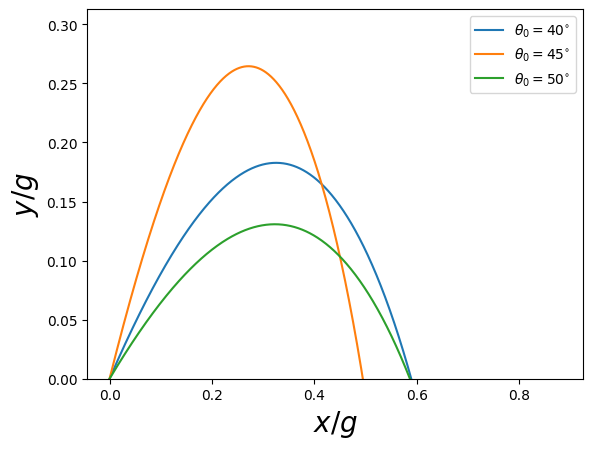

In [16]:
plt.plot(sol1.y[0],sol1.y[2], label=r'$\theta_0=40^{\circ}$')
plt.plot(sol2.y[0],sol2.y[2], label=r'$\theta_0=45^{\circ}$')
plt.plot(sol3.y[0],sol3.y[2], label=r'$\theta_0=50^{\circ}$')
plt.ylim(bottom=0)
plt.legend()
plt.xlabel('$x/g$', fontsize=20)
plt.ylabel('$y/g$', fontsize=20)
plt.show()